# **Importing Libraries**

In [74]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

# Data Visualization

In [75]:
train = list(os.walk('drive/MyDrive/train'))

In [78]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'rebar': 0, 'spalling': 1, 'crack': 2}


In [79]:
def dataset(path): 
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels
images, labels = dataset('drive/MyDrive/train')
images, labels = shuffle(images, labels)

100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


In [80]:
images.shape

(59, 150, 150, 3)

# Total No. of Defect

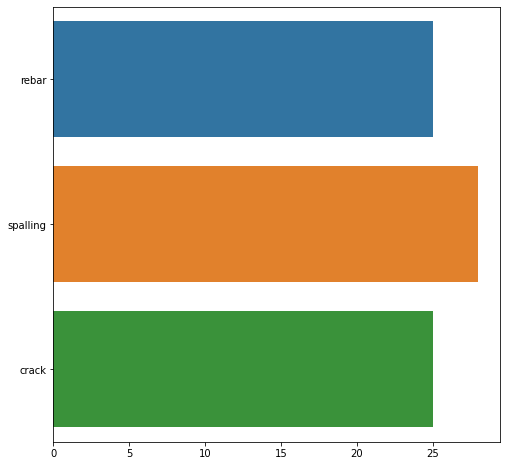

In [104]:
types = train[0][1]
number = []
for _ in range(1, 4):
    number.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = types, x = number);

# **Sample images**

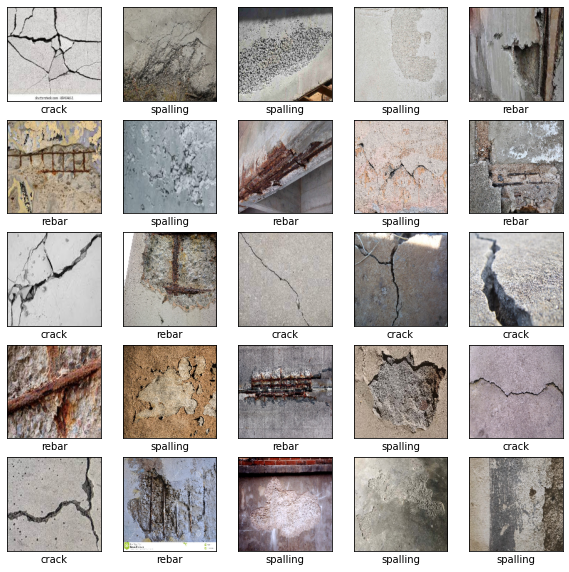

In [105]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# **Load images using ImageDatagenerator**

In [106]:
image_size = (224, 224)
batch_size = 3
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [107]:
train_ds = train_datagen.flow_from_directory('drive/MyDrive/train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('drive/MyDrive/train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 48 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


In [108]:
train_ds.class_indices

{'crack': 0, 'rebar': 1, 'spalling': 2}

# **Some augmented images**

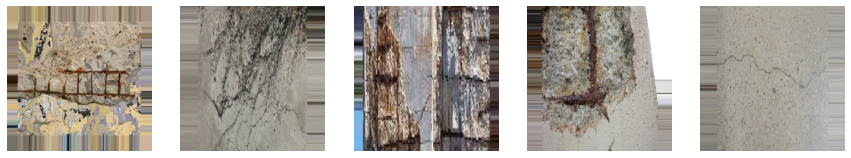

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# **Transfer learning**

### **VGG16**

In [110]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

In [111]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation = 'sigmoid')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f7cc1a5cfd0>>

In [112]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [113]:
epochs = 25
vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 29s 2s/step - loss: 1.2745 - categorical_accuracy: 0.3542 - val_loss: 0.9670 - val_categorical_accuracy: 0.3636
Epoch 2/25
16/16 [==============================] - 26s 2s/step - loss: 0.9179 - categorical_accuracy: 0.6458 - val_loss: 0.8193 - val_categorical_accuracy: 0.7273
Epoch 3/25
16/16 [==============================] - 26s 2s/step - loss: 0.8838 - categorical_accuracy: 0.5208 - val_loss: 0.8408 - val_categorical_accuracy: 0.6364
Epoch 4/25
16/16 [==============================] - 26s 2s/step - loss: 0.8432 - categorical_accuracy: 0.5208 - val_loss: 0.6638 - val_categorical_accuracy: 0.6364
Epoch 5/25
16/16 [==============================] - 28s 2s/step - loss: 0.7679 - categorical_accuracy: 0.6667 - val_loss: 0.7427 - val_categorical_accuracy: 0.7273
Epoch 6/25
16/16 [==============================] - 26s 2s/step - loss: 0.5955 - categorical_accuracy: 0.7708 - val_loss: 0.5530 - val_categorical_accuracy: 0.9091
Epoch 7/25
16/16 [=========

In [114]:
vgg_model.save('vgg.hdf5')

# **Testing Model on Own Image**

In [115]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nclass: {0} \nDefect Type: {1}'.format(clas, name))

1/1 [==============================] - 1s 510ms/step
The given image is of 
class: 0 
Defect Type: crack


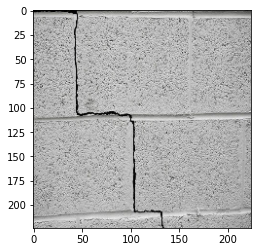

In [116]:
predictor('drive/MyDrive/validation/testCrack4.jpg', vgg_model)

1/1 [==============================] - 0s 413ms/step
The given image is of 
class: 2 
Defect Type: spalling


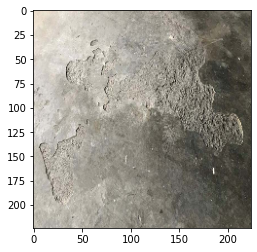

In [117]:
predictor('drive/MyDrive/validation/testSpall5.jpg', vgg_model)

1/1 [==============================] - 0s 397ms/step
The given image is of 
class: 0 
Defect Type: crack


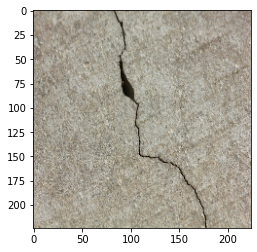

In [118]:
predictor('drive/MyDrive/validation/testCrack2.jpg', vgg_model)

1/1 [==============================] - 1s 694ms/step
The given image is of 
class: 1 
Defect Type: rebar


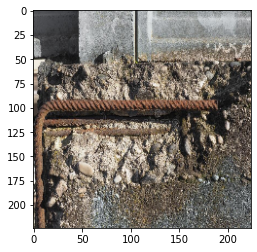

In [119]:
predictor('drive/MyDrive/validation/testRebar5.jpg', vgg_model)

1/1 [==============================] - 0s 410ms/step
The given image is of 
class: 1 
Defect Type: rebar


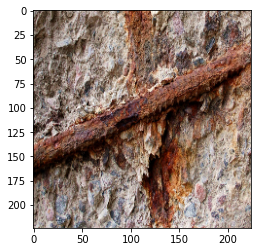

In [120]:
predictor('drive/MyDrive/validation/testRebar3.jpg', vgg_model)

1/1 [==============================] - 0s 408ms/step
The given image is of 
class: 2 
Defect Type: spalling


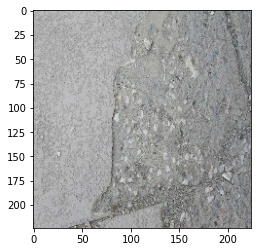

In [121]:
predictor('drive/MyDrive/validation/testSpall4.jpg', vgg_model)

1/1 [==============================] - 0s 406ms/step
The given image is of 
class: 0 
Defect Type: crack


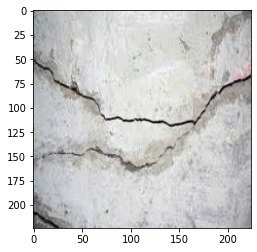

In [122]:
predictor('drive/MyDrive/validation/testCrack3.jpg', vgg_model)